In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from utils.pandas import apply_filters
from utils_local import read_spreadsheet, colors_v1, markers_v1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### All results w.r.t. Kinetics-400

In [5]:
# load domain-shift results
from utils_local import load_domain_shift_results, scatter_with_correlation

k400_values, df_linear, df_finetune = load_domain_shift_results(remove_K400=True)
ucf101_values = {"Method": list(df_finetune.index), "finetune": df_finetune["UCF101"].values}

In [6]:
def get_xvalues_for_correlation(key="K400-linear", remove_moco=False):
    assert key in ["K400-linear", "UCF101-finetune"]
    xaxis, subkey = key.split("-")

    if xaxis == "K400":
        xvalues = k400_values[subkey]
        xmethods = k400_values["Method"]
        xlabel = "K400 Linear"
    elif xaxis == "UCF101":
        xvalues = ucf101_values[subkey]
        xmethods = ucf101_values["Method"]
        xlabel = "UCF-101 Finetuning"
    else:
        raise ValueError
    
    if remove_moco:
        xmethods = list(xmethods)
        moco_index = xmethods.index("MoCo")
        xmethods = [x for i, x in enumerate(xmethods) if i != moco_index]
        xvalues = [x for i, x in enumerate(xvalues) if i != moco_index]
    
    return xmethods, xvalues, xlabel

In [7]:
# load granularity results

from utils_local import load_finegym_results

df_granularity = load_finegym_results()
# extract per-class results
df_class = df_granularity[[x for x in df_granularity.columns if "class" in x or "Method" in x]]
df_class = df_class.set_index(keys=["Method"])
df_class.columns = [x.replace(" (class)", "") for x in df_class.columns]

In [8]:
# load task-shift results

from utils_local import load_task_shift_results

df_task = load_task_shift_results()

In [9]:
# load dataset size results

df_size = read_spreadsheet(gid_key="dataset_size")
df_size.dropna(inplace=True)

dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

for d, v in dataset_full_size.items():
    indices = (df_size.Dataset == d) * (df_size["Dataset size"] == "Full")
    df_size.at[indices, "Dataset size (float)"] = v
df_size["Dataset size (float)"] = df_size["Dataset size (float)"].astype(float)

In [10]:
df_linear

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00
MoCo,65.40,29.53,29.66,9.68,21.40
SeLaVi,51.18,15.74,20.23,4.51,22.42
VideoMoCo,66.27,51.58,41.57,19.54,25.67
Pretext-contrast,57.15,17.61,29.98,10.86,20.04
RSPNet,76.63,33.47,32.16,12.52,24.82
AVID-CMA,78.14,53.93,45.12,16.12,22.53
CTP,37.93,22.58,30.62,12.20,20.04
TCLR,63.26,33.45,33.04,10.84,21.82
GDT,75.73,38.21,34.15,11.87,25.34


In [11]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
MoCo,83.80,93.41,83.62,52.42,26.40
SeLaVi,84.88,92.78,88.93,56.37,33.77
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
RSPNet,88.47,93.90,91.28,59.39,42.67
AVID-CMA,89.33,93.99,90.56,53.82,29.91
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.97,36.18
GDT,91.14,93.89,90.36,57.78,37.26


In [12]:
df_class

,Gym99 (99),Gym288 (288),Vault (6),FX (35),FX-S1 (11),UB-S1 (15)
Method,,,,,,
None,84.40,50.01,24.67,75.88,44.98,83.98
MoCo,83.62,51.65,32.10,82.95,62.21,84.14
SeLaVi,84.75,52.82,25.44,76.04,50.15,81.46
VideoMoCo,86.36,54.07,27.78,79.52,60.39,82.07
Pretext-contrast,85.70,52.66,28.48,81.37,65.78,86.24
RSPNet,87.59,55.20,33.35,82.72,63.50,85.12
AVID-CMA,85.83,52.46,30.35,82.65,67.15,88.41
CTP,88.33,56.51,26.83,86.16,79.66,88.44
TCLR,87.97,55.37,29.84,84.25,61.02,85.29


In [13]:
df_task

,UCF - Action recognition (Top-1),UCF - Spatio-temporal (IoU@0.5),UCF - Repetition (1 - MAE),UCF - AoT (Top-1),Charades - Multi-label (mAP),AVA - Spatio-temporal (mAP)
Method,,,,,,
None,75.36,0.327300,0.7680,56.106,7.895,7.890
MoCo,83.48,0.415500,0.7805,80.330,8.134,11.713
SeLaVi,84.88,0.419200,0.8288,77.439,8.218,10.227
VideoMoCo,85.83,0.440100,0.8289,72.905,10.454,13.097
Pretext-contrast,86.61,0.461900,0.8315,77.227,8.930,12.653
RSPNet,88.47,0.466909,0.8490,86.955,9.146,14.057
AVID-CMA,89.33,0.435400,0.8381,83.254,8.350,10.014
CTP,89.77,0.464600,0.8217,77.055,9.645,10.081
TCLR,90.77,0.476400,0.8507,85.633,11.135,10.809


In [14]:
df_size

,Method,Dataset,Dataset size,Top-1,Dataset size (float)
0,No pretraining,UCF,1000,43.14,NaN
1,SELAVI,UCF,1000,69.18,NaN
2,RSPNET,UCF,1000,75.68,NaN
3,Video Moco,UCF,1000,65.82,NaN
4,Pretext-Contrast,UCF,1000,62.70,NaN
...,...,...,...,...,...
304,TCLR,SS,Full,59.64,169000.0
305,GDT,SS,Full,57.78,169000.0
306,AVID-CMA,SS,Full,53.82,169000.0
307,MoCo,SS,Full,52.42,169000.0


In [15]:
def beautify_ax(
        ax, subtitle="My subplot", subtitlesize=20, xlabel="", xrotation=0,
        ylabel="", yrotation=0, xmargin=0.0, grid_alpha=0.3, ylim=None,
    ):
    
    tickssize = 0.7 * subtitlesize
    legendsize = 0.7 * subtitlesize
    xlabelsize = 0.8 * subtitlesize
    ylabelsize = 0.8 * subtitlesize

    ax.grid(alpha=grid_alpha)
    ax.set_title(subtitle, fontsize=subtitlesize)
    ax.set_xlabel(xlabel, fontsize=xlabelsize)
    ax.set_ylabel(ylabel, fontsize=ylabelsize)

    ax.tick_params(axis='y', which='major', labelsize=tickssize, rotation=yrotation)
    ax.tick_params(axis='x', which='major', labelsize=tickssize, rotation=xrotation)
    ax.margins(x=xmargin)
    
    if ylim is not None:
        ax.set_ylim(ylim)

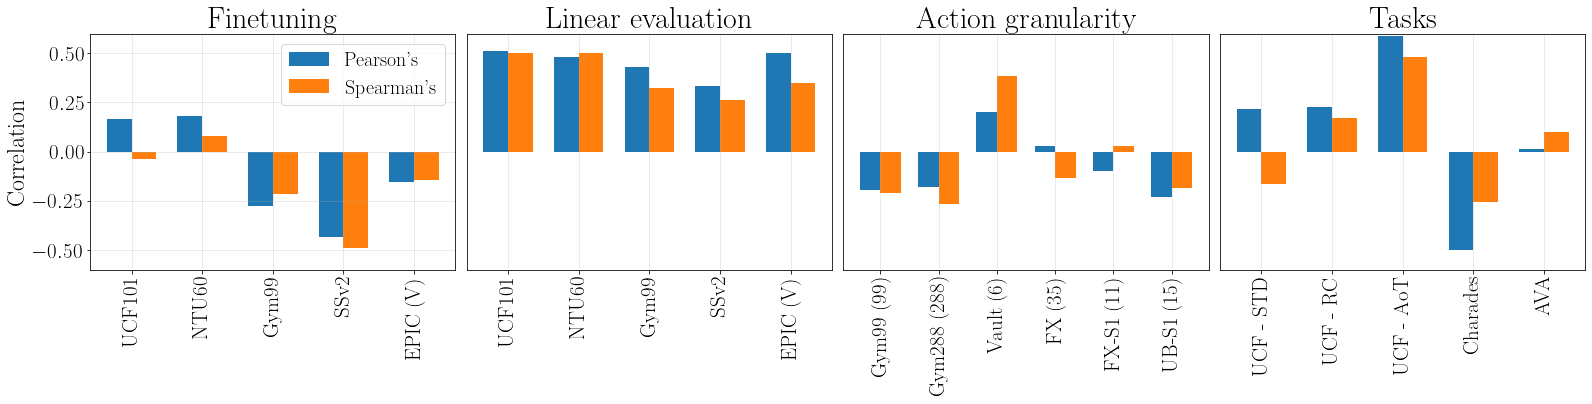

In [16]:
figsize = (22, 5.5)
nrows, ncols = 1, 4
width_per_ax = figsize[0] // ncols
height_per_ax = figsize[1] // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)

def barplot_per_ax(ax, df, width=0.35):
    
    corr = df.corr(method="pearson").loc["K400 Linear"].drop("K400 Linear")
    xticks = list(corr.index)
    x = np.arange(len(xticks))
    
    ax.bar(x=x, height=corr.values, width=width, label="Pearson's")
    corr = df.corr(method="spearman").loc["K400 Linear"].drop("K400 Linear")
    ax.bar(x=x + width, height=corr.values, width=width, label="Spearman's")

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(xticks)

ylim=None
ylim = (-0.6, 0.6)
xmargin = 0.05
legendsize = 20

xmethods, xvalues, xlabel = get_xvalues_for_correlation("K400-linear", remove_moco=False)

ax = axes[0]
beautify_ax(ax=ax, subtitle="Finetuning", subtitlesize=30, ylabel="Correlation", xmargin=xmargin, xrotation=90, ylim=ylim)
df = df_finetune.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
barplot_per_ax(ax, df)
ax.legend(fontsize=legendsize)

ax = axes[1]
beautify_ax(ax=ax, subtitle="Linear evaluation", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
df = df_linear.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

ax = axes[2]
beautify_ax(ax=ax, subtitle="Action granularity", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
df = df_class.copy()
df[xlabel] = xvalues
df = df.loc[np.array(xmethods)].reset_index()
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

ax = axes[3]
beautify_ax(ax=ax, subtitle="Tasks", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
xmethods, xvalues, xlabel = get_xvalues_for_correlation("K400-linear", remove_moco=False)
df = df_task.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
df = df.rename(
    columns={
        "UCF - Action recognition (Top-1)": "UCF - AR",
        "UCF - Spatio-temporal (IoU@0.5)": "UCF - STD",
        "UCF - AoT (Top-1)": "UCF - AoT",
        "UCF - Repetition (1 - MAE)": "UCF - RC",
        "Charades - Multi-label (mAP)": "Charades",
        "AVA - Spatio-temporal (mAP)": "AVA",
    },
)
remove_action_rec_on_ucf=True
if remove_action_rec_on_ucf:
    df.drop(columns=["UCF - AR"], inplace=True)
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

plt.savefig(f"../../results/plots/both_correlations_on_{xlabel}_v2.pdf", bbox_inches="tight")
plt.show()

In [17]:
df_linear

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00
MoCo,65.40,29.53,29.66,9.68,21.40
SeLaVi,51.18,15.74,20.23,4.51,22.42
VideoMoCo,66.27,51.58,41.57,19.54,25.67
Pretext-contrast,57.15,17.61,29.98,10.86,20.04
RSPNet,76.63,33.47,32.16,12.52,24.82
AVID-CMA,78.14,53.93,45.12,16.12,22.53
CTP,37.93,22.58,30.62,12.20,20.04
TCLR,63.26,33.45,33.04,10.84,21.82
GDT,75.73,38.21,34.15,11.87,25.34


In [18]:
df

,UCF - STD,UCF - RC,UCF - AoT,Charades,AVA,K400 Linear
Method,,,,,,
None,0.327300,0.7680,56.106,7.895,7.890,0.00
MoCo,0.415500,0.7805,80.330,8.134,11.713,36.24
SeLaVi,0.419200,0.8288,77.439,8.218,10.227,24.05
VideoMoCo,0.440100,0.8289,72.905,10.454,13.097,30.99
Pretext-contrast,0.461900,0.8315,77.227,8.930,12.653,22.35
RSPNet,0.466909,0.8490,86.955,9.146,14.057,42.84
AVID-CMA,0.435400,0.8381,83.254,8.350,10.014,43.49
CTP,0.464600,0.8217,77.055,9.645,10.081,7.61
TCLR,0.476400,0.8507,85.633,11.135,10.809,19.84


In [19]:
xmethods

['None',
 'MoCo',
 'SeLaVi',
 'VideoMoCo',
 'Pretext-contrast',
 'RSPNet',
 'AVID-CMA',
 'CTP',
 'TCLR',
 'GDT',
 'Supervised']

In [20]:
xvalues

array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
       38.61,  0.  ])

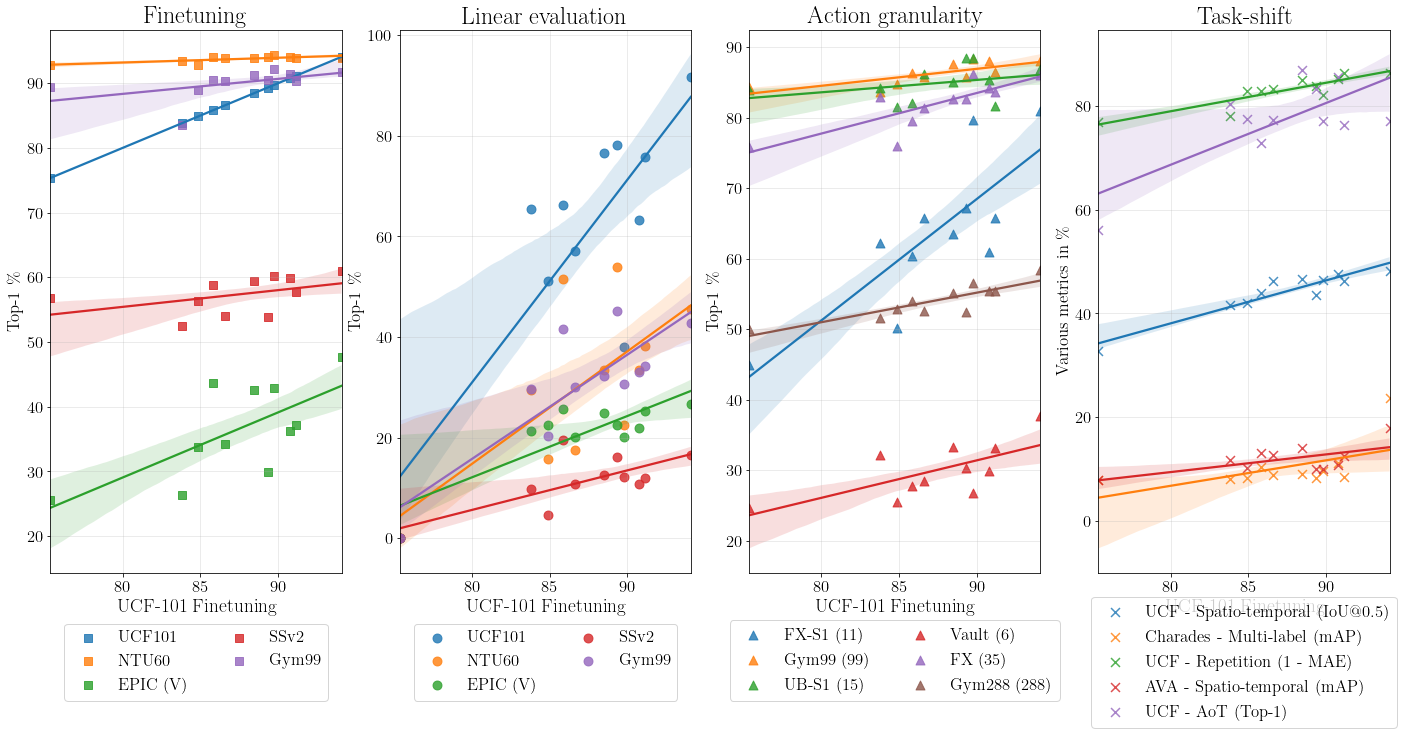

In [21]:
figsize = (24, 10)
nrows, ncols = 1, 4
width_per_ax = figsize[0] // ncols
height_per_ax = figsize[1] // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

subtitlesize = (width_per_ax * height_per_ax) // 2.5
tickssize = 0.7 * subtitlesize
legendsize = 0.7 * subtitlesize
xlabelsize = 0.8 * subtitlesize
ylabelsize = 0.7 * subtitlesize

markersize=80
scatter_kws={'s': markersize}

def regplot_for_df(ax, df, xlabel, ylabel, subtitle, show_xlabel=True, xmargin=0.0, ci=95, marker="o", scatter_kws=scatter_kws):

    for col in set(df.columns) - {xlabel}:
        sns.regplot(data=df, x=xlabel, y=col, label=col, ax=ax, ci=ci, marker=marker, scatter_kws=scatter_kws)
    ax.legend(fontsize=legendsize)
    
    ax.grid(alpha=0.3)
    ax.set_title(subtitle, fontsize=subtitlesize)
    if show_xlabel:
        ax.set_xlabel(xlabel, fontsize=xlabelsize)
    else:
        ax.set_xlabel("")
    ax.set_ylabel(ylabel, fontsize=ylabelsize)
    ax.tick_params(axis='y', which='major', labelsize=tickssize, rotation=0)
    ax.tick_params(axis='x', which='major', labelsize=tickssize, rotation=0)
    ax.margins(x=xmargin)

# key = "K400-linear"
key = "UCF101-finetune"
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key, remove_moco=False)
ci = 80

# plot domain shift for linear evaluation
ax = axes[1]
df = df_linear.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Linear evaluation", ci=ci, marker="o")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot domain shift for finetuning
ax = axes[0]
df = df_finetune.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Finetuning", ci=ci, marker="s")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot granularity shift
ax = axes[2]
df = df_class.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Action granularity", ci=ci, marker="^")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot task shift
ax = axes[3]
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key, remove_moco=False)
df = df_task.copy()
df[xlabel] = xvalues
normalize = True
if normalize:
    # df = (df - df.min()) / (df.max() - df.min())
    df["UCF - Spatio-temporal (IoU@0.5)"] *= 100.
    df["UCF - Repetition (1 - MAE)"] *= 100.
remove_ucf_action_rec = True
if remove_ucf_action_rec:
    df.drop(columns=["UCF - Action recognition (Top-1)"], inplace=True)
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Various metrics in \\%", subtitle="Task-shift", ci=ci,
               show_xlabel=True, marker="x")
legend_kwargs = dict(
    ncol=1,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.3),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)

# plt.savefig(f"../../results/plots/correlations_all_on_{xlabel}_ci_{ci}.pdf", bbox_inches="tight")
plt.show()

1. ~Use different markers for different subplots~
2. ~Plot with 80% and 95% CI and put them in overleaf (one in appendix)~
3. ~Remove UCF action recognition from Task-shift~
4. ~Add `K400 Linear` for Task shift as well~
5. ~Try adding avg of dataset sizes as 5th subplot in the above plot~
6. ~No need to have domain-shift in titles here~
7. ~Swap orders of Finetune and Linear. Then varying dataset size~


1. Bar-plot for Spearman rank correlations similar to Fig 2 in Edinburgh


1. Dataset size bar plot for